In [49]:
import pandas as pd
import os
import scipy.stats as st
import numpy as np
import statsmodels.stats.multitest as smt
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import kruskal

# from statannotations.Annotator import Annotator

In [50]:
# load the SpiecEasi results

density_all = pd.read_csv("../../Input/SpiecEasi/edge_density_all_OTUs.csv")
metrics_all = pd.read_csv("../../Input/SpiecEasi/network_metrics_all_OTUs.csv", index_col=0)

density_forest = pd.read_csv("../../Input/SpiecEasi/edge_density_ForestWoodland.csv")
metrics_forest = pd.read_csv("../../Input/SpiecEasi/network_metrics_ForestWoodland.csv", index_col=0)

density_barren = pd.read_csv("../../Input/SpiecEasi/edge_density_Barren.csv")
metrics_barren = pd.read_csv("../../Input/SpiecEasi/network_metrics_Barren.csv", index_col=0)

density_wetland = pd.read_csv("../../Input/SpiecEasi/edge_density_Wetland.csv")
metrics_wetland = pd.read_csv("../../Input/SpiecEasi/network_metrics_Wetland.csv", index_col=0)

density_shrubland = pd.read_csv("../../Input/SpiecEasi/edge_density_Shrubland.csv")
metrics_shrubland = pd.read_csv("../../Input/SpiecEasi/network_metrics_Shrubland.csv", index_col=0)

density_herbaceous = pd.read_csv("../../Input/SpiecEasi/edge_density_Herbaceous.csv")
metrics_herbaceous = pd.read_csv("../../Input/SpiecEasi/network_metrics_Herbaceous.csv", index_col=0)

density_steppe = pd.read_csv("../../Input/SpiecEasi/edge_density_SteppeSavanna.csv")
metrics_steppe = pd.read_csv("../../Input/SpiecEasi/network_metrics_SteppeSavanna.csv", index_col=0)

# load the relative abundance of abundant taxa, rare taxa, generalists, specialists
df_abun = pd.read_csv("../../Input/abun_relabun.csv", index_col=0)
df_rare = pd.read_csv("../../Input/rare_relabun.csv", index_col=0)
df_gen = pd.read_csv("../../Input/gen_relabun.csv", index_col=0)
df_spe = pd.read_csv("../../Input/spe_relabun.csv", index_col=0)

# load the taxonomy data
taxon = pd.read_csv("../../Input/OTU_taxon.csv", index_col=0)

In [51]:
# reset index of the density dataframe using group names

density_all.index = ['All']
density_forest.index = ['Forest/Woodland']
density_barren.index = ['Barren']
density_wetland.index = ['Wetland']
density_shrubland.index = ['Shrubland']
density_herbaceous.index = ['Herbaceous']
density_steppe.index = ['Steppe/Savanna']

# Modify the index of the network metrics dataframes by concatenating the prefix "OTU_"
prefix = 'OTU_'
metrics_all.index = metrics_all.index.astype(str).map(lambda x: prefix + x)
metrics_forest.index = metrics_forest.index.astype(str).map(lambda x: prefix + x)
metrics_barren.index = metrics_barren.index.astype(str).map(lambda x: prefix + x)
metrics_wetland.index = metrics_wetland.index.astype(str).map(lambda x: prefix + x)
metrics_shrubland.index = metrics_shrubland.index.astype(str).map(lambda x: prefix + x)
metrics_herbaceous.index = metrics_herbaceous.index.astype(str).map(lambda x: prefix + x)
metrics_steppe.index = metrics_steppe.index.astype(str).map(lambda x: prefix + x)

In [52]:
# function to load edge weight data and melt edge weight matrix

def load_melt_edge_wt(path_to_the_file):
    edge_wt = pd.read_csv(path_to_the_file, index_col=0)
    edge_wt.index = edge_wt.index.astype(str).map(lambda x: 'V' + x) # add 'V' to index to match with column names

    edge_wt_melted = edge_wt.where(np.triu(np.ones(edge_wt.shape)).astype(bool)) # get upper triangle distance
    edge_wt_melted = edge_wt_melted.melt(ignore_index=False).dropna()

    edge_wt_melted.index.name = 'Sample i'
    edge_wt_melted.columns = ['Sample j', 'weight']
    edge_wt_melted = edge_wt_melted.reset_index()

    edge_wt_melted_filtered = edge_wt_melted[edge_wt_melted['Sample i'] != edge_wt_melted['Sample j']] # remove rows with OTUs comparing themselves
    edge_wt_melted_filtered = edge_wt_melted_filtered[edge_wt_melted_filtered['weight'] != 0] # remove weight = 0

    return edge_wt_melted_filtered


# Network edge weight summary for all OTUs

need to switch to leaph-US_soil_microbiome_16s environment for the seaborn histgram

In [3]:
# load and melt edge weight data for all OTUs
edge_wt_all = load_melt_edge_wt("../../Input/SpiecEasi/edge_weight_all_OTUs.csv")

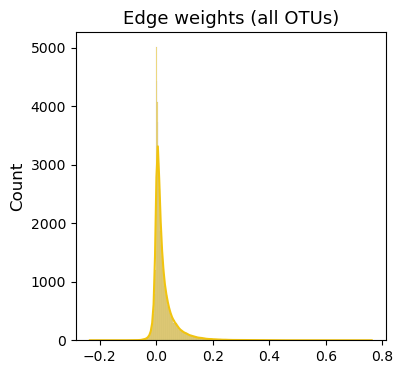

In [27]:
plt.rcParams["figure.figsize"] = (4, 4)

sns.histplot(data=edge_wt_all, x='weight', color="#F1C40F", kde=True)
plt.xlabel("")
plt.ylabel("Count", fontsize=12)
plt.title("Edge weights (all OTUs)", fontsize=13)
plt.savefig("../output/edge_weight_all_hist.pdf", bbox_inches="tight", dpi=300)
plt.show()

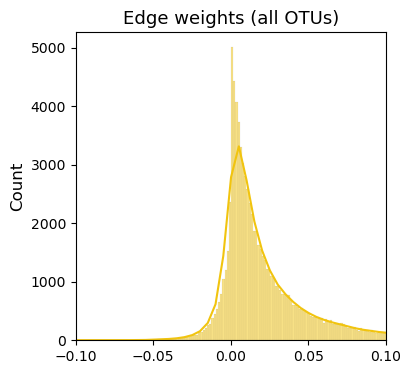

In [28]:
plt.rcParams["figure.figsize"] = (4, 4)

sns.histplot(data=edge_wt_all, x='weight', color="#F1C40F", kde=True)
plt.xlabel("")
plt.ylabel("Count", fontsize=12)
plt.title("Edge weights (all OTUs)", fontsize=13)
plt.xlim(-0.1, 0.1)
plt.savefig("../output/edge_weight_all_hist_sub.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [10]:
# a function to count number of edge weights > 0 and < 0 and make a pie chart
def edge_wt_pos_neg_ct_pie(edge_wt_df, color, title, path_to_file):
    count_positive = (edge_wt_df['weight'] > 0).sum()
    count_negative = (edge_wt_df['weight'] < 0).sum()

    counts = pd.Series([count_positive, count_negative], index=['Postive', 'Negative'])

    plt.rcParams["figure.figsize"] = (4, 4)
    counts.plot(kind='pie', autopct='%1.1f%%', colors=color, startangle=90, textprops={'fontsize': 12})
    plt.title(title, size = 14)
    plt.xlabel('')
    plt.ylabel('')
    plt.savefig(path_to_file, bbox_inches="tight", dpi=300)
    plt.show()

    return (count_positive, count_negative)

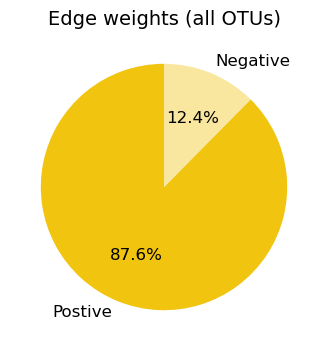

(72764, 10309)

In [29]:
edge_wt_pos_neg_ct_pie(edge_wt_all, ['#F1C40F', '#F9E79F'], 'Edge weights (all OTUs)', "../output/edge_weight_all_pie.pdf")

# Network comparison among ecosystems

### Network density

In [53]:
density_concat = pd.concat([density_forest, density_barren, density_wetland, density_shrubland, density_herbaceous, density_steppe])
density_concat.index.names = ['group']
density_concat = density_concat.reset_index()
density_concat = density_concat.sort_values(by = 'edge density')

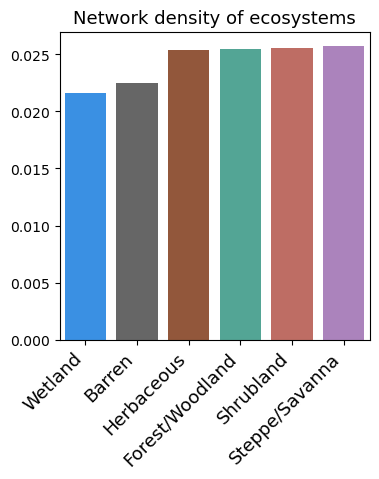

In [55]:
group_colors = {
    'Forest/Woodland': '#45B39D',
    'Barren': '#666666',
    'Wetland': '#1E90FF',
    'Shrubland': '#CD6155',
    'Herbaceous': '#A0522D',
    'Steppe/Savanna': '#AF7AC5'
}

plt.rcParams["figure.figsize"] = (4, 4)

ax = sns.barplot(data = density_concat, x='group', y="edge density", hue='group', palette=group_colors, dodge=False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Network density of ecosystems', size=13)
plt.xticks(fontsize=13, rotation=45, ha='right')
plt.savefig('../output/density_ecosystems.pdf', bbox_inches='tight', dpi=600)
plt.show()


### Edge weight 

In [58]:
# load and melt edge weight data for each ecosystem
edge_wt_forest = load_melt_edge_wt("../../Input/SpiecEasi/edge_weight_ForestWoodland.csv")

edge_wt_steppe = load_melt_edge_wt("../../Input/SpiecEasi/edge_weight_SteppeSavanna.csv")

edge_wt_herbaceous = load_melt_edge_wt("../../Input/SpiecEasi/edge_weight_Herbaceous.csv")

edge_wt_shrubland = load_melt_edge_wt("../../Input/SpiecEasi/edge_weight_Shrubland.csv")

edge_wt_wetland = load_melt_edge_wt("../../Input/SpiecEasi/edge_weight_Wetland.csv")

edge_wt_barren = load_melt_edge_wt("../../Input/SpiecEasi/edge_weight_Barren.csv")


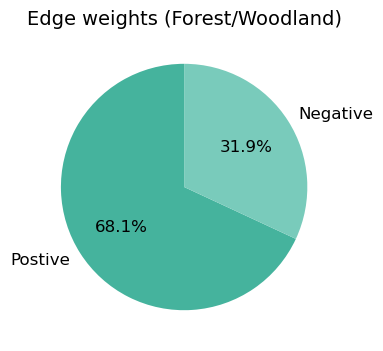

In [59]:
pos_ct_forest, neg_ct_forest = edge_wt_pos_neg_ct_pie(edge_wt_forest, ['#45B39D', '#79cbbb'],
                                                      'Edge weights (Forest/Woodland)',
                                                      "../output/edge_weight_forest_pie.pdf")

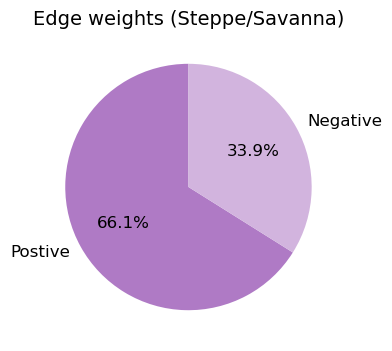

In [60]:
pos_ct_steppe, neg_ct_steppe = edge_wt_pos_neg_ct_pie(edge_wt_steppe, ['#AF7AC5', '#D2B4DE'],
                                                      'Edge weights (Steppe/Savanna)',
                                                      "../output/edge_weight_steppe_pie.pdf")

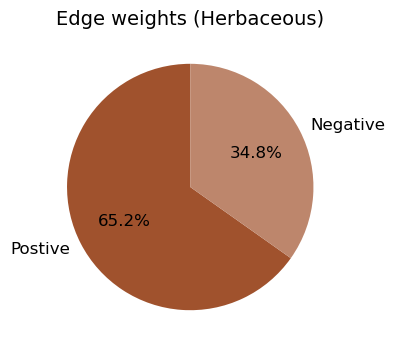

In [61]:
pos_ct_herbaceous, neg_ct_herbaceous = edge_wt_pos_neg_ct_pie(edge_wt_herbaceous, ['#A0522D', '#bd866c'],
                                                      'Edge weights (Herbaceous)',
                                                      "../output/edge_weight_herbaceous_pie.pdf")

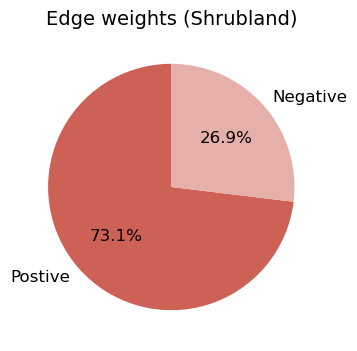

In [62]:
pos_ct_shrubland, neg_ct_shrubland = edge_wt_pos_neg_ct_pie(edge_wt_shrubland, ['#CD6155', '#E6B0AA'],
                                                      'Edge weights (Shrubland)',
                                                      "../output/edge_weight_shrubland_pie.pdf")

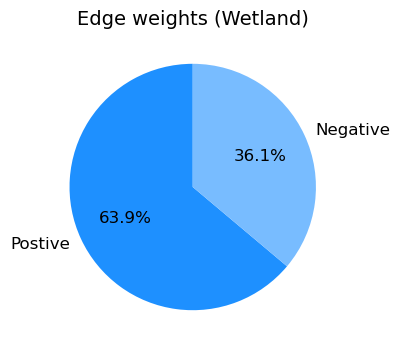

In [63]:
pos_ct_wetland, neg_ct_wetland = edge_wt_pos_neg_ct_pie(edge_wt_wetland, ['#1E90FF', '#78bcff'],
                                                      'Edge weights (Wetland)',
                                                      "../output/edge_weight_wetland_pie.pdf")

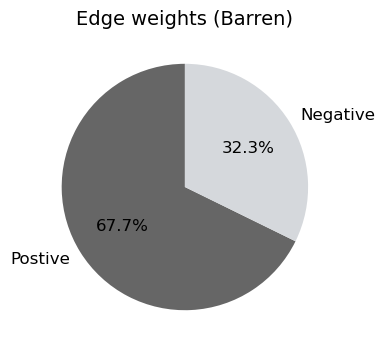

In [64]:
pos_ct_barren, neg_ct_barren = edge_wt_pos_neg_ct_pie(edge_wt_barren, ['#666666', '#D5D8DC'],
                                                      'Edge weights (Barren)',
                                                      "../output/edge_weight_barren_pie.pdf")

In [48]:
# Perform Fisher's exact test for counts of pos and neg edge weights

import numpy as np
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

stats = importr('stats')
m = np.array([[pos_ct_forest, neg_ct_forest], [pos_ct_barren, neg_ct_barren], [pos_ct_herbaceous, neg_ct_herbaceous],
     [pos_ct_shrubland, neg_ct_shrubland], [pos_ct_steppe, neg_ct_steppe], [pos_ct_wetland, neg_ct_wetland]])
res = stats.fisher_test(m, simulate_p_value=True)
print ('p-value: {}'.format(res[0][0]))

p-value: 0.0004997501249375312


### Node metrics

In [65]:
metrics_forest['group'] = 'Forest/Woodland'
metrics_barren['group'] = 'Barren'
metrics_wetland['group'] = 'Wetland'
metrics_shrubland['group'] = 'Shrubland'
metrics_herbaceous['group'] = 'Herbaceous'
metrics_steppe['group'] = 'Steppe/Savanna'

metrics_cancat = pd.concat([metrics_forest, metrics_barren, metrics_wetland, metrics_shrubland, metrics_herbaceous, metrics_steppe])

In [66]:
# KW test

kw_pval = {}

for i in ['degree', 'closeness', 'betweenness']:
    stat, p_value = kruskal(metrics_forest[i], metrics_barren[i], metrics_shrubland[i], metrics_wetland[i], metrics_herbaceous[i], metrics_steppe[i])
    kw_pval[i] = p_value

In [9]:
# define color code for ecosystems
group_colors = {
    'Forest/Woodland': '#45B39D',
    'Barren': '#666666',
    'Wetland': '#1E90FF',
    'Shrubland': '#CD6155',
    'Herbaceous': '#A0522D',
    'Steppe/Savanna': '#AF7AC5'
}

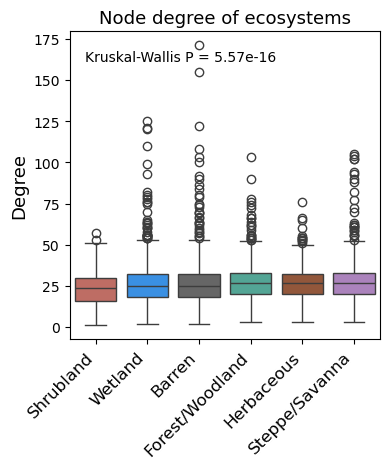

In [70]:
# Degree boxplot

order=['Shrubland', 'Wetland', 'Barren', 'Forest/Woodland', 'Herbaceous', 'Steppe/Savanna']

# pairs=[
#     ('Shrubland', 'Forest/Woodland'),
#     ('Shrubland', 'Wetland'),
#     ('Shrubland', 'Barren'),
#     ('Shrubland', 'Herbaceous'),
#     ('Shrubland', 'Steppe/Savanna'),
#     ('Forest/Woodland', 'Wetland'),
#     ('Forest/Woodland', 'Barren'),
#     ('Forest/Woodland', 'Herbaceous'),
#     ('Forest/Woodland', 'Steppe/Savanna'),
#     ('Wetland', 'Barren'),
#     ('Wetland', 'Herbaceous'),
#     ('Wetland', 'Steppe/Savanna'),
#     ('Barren', 'Herbaceous'),
#     ('Barren', 'Steppe/Savanna'),
#     ('Herbaceous', 'Steppe/Savanna'),
#     ]

plt.rcParams["figure.figsize"] = (4, 4)

ax = sns.boxplot(data=metrics_cancat, x='group', y='degree', order=order, hue='group', palette=group_colors, legend=False)
# annot = Annotator(ax, pairs, data=metrics_cancat, x='group', y='degree', order=order)
# annot.configure(test='Mann-Whitney', comparisons_correction="Benjamini-Hochberg", verbose=2)
# annot.apply_test()
# annot.annotate()
ax.set_xlabel('')
ax.set_ylabel('Degree', size=13)
ax.set_title('Node degree of ecosystems', size=13)

plt.text(0.05, 0.94, f'Kruskal-Wallis P = {kw_pval["degree"]:.2e}', fontsize=10, ha='left', va='top', transform=ax.transAxes)

plt.xticks(fontsize=12, rotation=45, ha='right')
# plt.ylim(-20, 450)
plt.savefig('../output/network_degree_ecosystems.pdf', bbox_inches='tight', dpi=600)
plt.show()

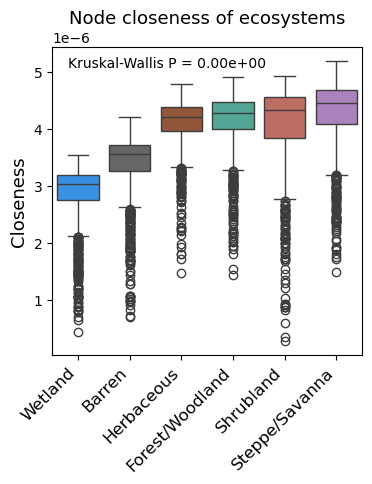

In [71]:
# Closeness boxplot

order=['Wetland', 'Barren', 'Herbaceous', 'Forest/Woodland', 'Shrubland', 'Steppe/Savanna']

# pairs=[
#     ('Wetland', 'Barren'),
#     ('Wetland', 'Forest/Woodland'),
#     ('Wetland', 'Herbaceous'),
#     ('Wetland', 'Shrubland'),
#     ('Wetland', 'Steppe/Savanna'),
#     ('Barren', 'Forest/Woodland'),
#     ('Barren', 'Herbaceous'),
#     ('Barren', 'Shrubland'),
#     ('Barren', 'Steppe/Savanna'),
#     ('Forest/Woodland', 'Herbaceous'),
#     ('Forest/Woodland', 'Shrubland'),
#     ('Forest/Woodland', 'Steppe/Savanna'),
#     ('Herbaceous', 'Shrubland'),
#     ('Herbaceous', 'Steppe/Savanna'),
#     ('Shrubland', 'Steppe/Savanna'),
#     ]

plt.rcParams["figure.figsize"] = (4, 4)

ax = sns.boxplot(data=metrics_cancat, x='group', y='closeness', order=order, hue='group', palette=group_colors, legend=False)
# annot = Annotator(ax, pairs, data=metrics_cancat, x='group', y='closeness', order=order)
# annot.configure(test='Mann-Whitney', comparisons_correction="Benjamini-Hochberg", verbose=2)
# annot.apply_test()
# annot.annotate()
ax.set_xlabel('')
ax.set_ylabel('Closeness', size=13)
ax.set_title('Node closeness of ecosystems', size=13)

plt.text(0.05, 0.97, f'Kruskal-Wallis P = {kw_pval["closeness"]:.2e}', fontsize=10, ha='left', va='top', transform=ax.transAxes)

plt.xticks(fontsize=12, rotation=45, ha='right')
# plt.ylim(0, 1.5e-5)
plt.savefig('../output/network_closeness_ecosystems.pdf', bbox_inches='tight', dpi=600)
plt.show()

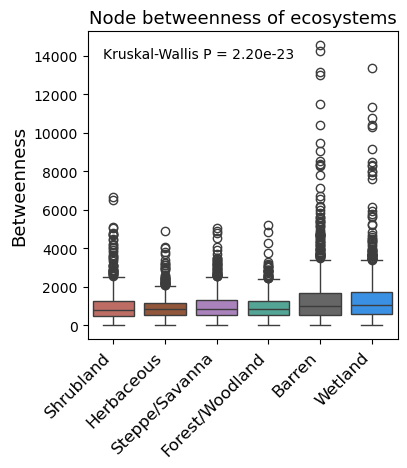

In [72]:
# Betweenness boxplot

order=['Shrubland', 'Herbaceous', 'Steppe/Savanna', 'Forest/Woodland', 'Barren', 'Wetland']

# pairs=[
#     ('Shrubland', 'Herbaceous'),
#     ('Shrubland', 'Forest/Woodland'),
#     ('Shrubland', 'Steppe/Savanna'),
#     ('Shrubland', 'Barren'),
#     ('Shrubland', 'Wetland'),
#     ('Herbaceous', 'Forest/Woodland'),
#     ('Herbaceous', 'Steppe/Savanna'),
#     ('Herbaceous', 'Barren'),
#     ('Herbaceous', 'Wetland'),
#     ('Forest/Woodland', 'Steppe/Savanna'),
#     ('Forest/Woodland', 'Barren'),
#     ('Forest/Woodland', 'Wetland'),
#     ('Steppe/Savanna', 'Barren'),
#     ('Steppe/Savanna', 'Wetland'),
#     ('Barren', 'Wetland'),
#     ]

plt.rcParams["figure.figsize"] = (4, 4)

ax = sns.boxplot(data=metrics_cancat, x='group', y='betweenness', order=order, hue='group', palette=group_colors, legend=False)
# annot = Annotator(ax, pairs, data=metrics_cancat, x='group', y='betweenness', order=order)
# annot.configure(test='Mann-Whitney', comparisons_correction="Benjamini-Hochberg", verbose=2)
# annot.apply_test()
# annot.annotate()
ax.set_xlabel('')
ax.set_ylabel('Betweenness', size=13)
ax.set_title('Node betweenness of ecosystems', size=13)

plt.text(0.05, 0.95, f'Kruskal-Wallis P = {kw_pval["betweenness"]:.2e}', fontsize=10, ha='left', va='top', transform=ax.transAxes)
plt.xticks(fontsize=12, rotation=45, ha='right')
# plt.ylim(-1000, 42000)
plt.savefig('../output/network_betweenness_ecosystems.pdf', bbox_inches='tight', dpi=600)
plt.show()

# Network node metrics comparison for ecotypes

In [204]:
metrics_abun = metrics_all[metrics_all.index.isin(df_abun.index)]
metrics_abun['Ecotype'] = 'Abundant taxa'

metrics_rare = metrics_all[metrics_all.index.isin(df_rare.index)]
metrics_rare['Ecotype'] = 'Rare taxa'

metrics_gen = metrics_all[metrics_all.index.isin(df_gen.index)]
metrics_gen['Ecotype'] = 'Generalists'

metrics_spe = metrics_all[metrics_all.index.isin(df_spe.index)]
metrics_spe['Ecotype'] = 'Specialists'

metrics_ecotype = pd.concat([metrics_abun, metrics_rare, metrics_gen, metrics_spe])

/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_8900/1452089123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_abun['Ecotype'] = 'Abundant taxa'
/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_8900/1452089123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_rare['Ecotype'] = 'Rare taxa'
/var/folders/5h/7h8l0j1s1mj4_v25_lxmx1lw0000gn/T/ipykernel_8900/1452089123.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [205]:
# KW test

kw_pval = {}

for i in ['degree', 'closeness', 'betweenness']:
    stat, p_value = kruskal(metrics_abun[i], metrics_rare[i], metrics_gen[i], metrics_spe[i])
    kw_pval[i] = p_value

In [206]:

order=['Abundant taxa', 'Rare taxa', 'Generalists', 'Specialists']

# define color code for ecotypes
group_colors = {
    'Abundant taxa': '#5499C7',
    'Rare taxa': '#D4AC0D',
    'Generalists': '#EC7063',
    'Specialists': '#45B39D'
}

# define comparison pairs
pairs=[
    ('Abundant taxa', 'Rare taxa'),
    ('Abundant taxa', 'Generalists'),
    ('Abundant taxa', 'Specialists'),
    ('Rare taxa', 'Generalists'),
    ('Rare taxa', 'Specialists'),
    ('Generalists', 'Specialists'),
    ]

plt.rcParams["figure.figsize"] = (3, 4)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Abundant taxa vs. Rare taxa: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.361e-08 U_stat=6.538e+04
Rare taxa vs. Generalists: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.318e-01 U_stat=6.573e+04
Generalists vs. Specialists: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.603e-01 U_stat=1.287e+04
Abundant taxa vs. Generalists: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.299e-05 U_stat=1.172e+04
Rare taxa vs. Specialists: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.905e-01 U_stat=6.964e+04
Abundant taxa vs. Specialists: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.132e-04 U_stat=1.270e+04


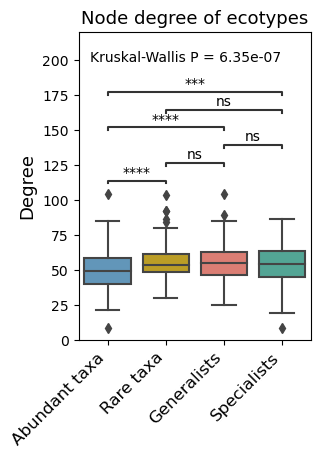

In [207]:
# Degree boxplot

ax = sns.boxplot(data=metrics_ecotype, x='Ecotype', y='degree', order=order, palette=group_colors)
annot = Annotator(ax, pairs, data=metrics_ecotype, x='Ecotype', y='degree', order=order)
annot.configure(test='Mann-Whitney', comparisons_correction="Benjamini-Hochberg", verbose=2)
annot.apply_test()
annot.annotate()
ax.set_xlabel('')
ax.set_ylabel('Degree', size=13)
ax.set_title('Node degree of ecotypes', size=13)

plt.text(0.05, 0.94, f'Kruskal-Wallis P = {kw_pval["degree"]:.2e}', fontsize=10, ha='left', va='top', transform=ax.transAxes)

plt.xticks(fontsize=12, rotation=45, ha='right')
plt.ylim(0, 220)
plt.savefig('../output/network_degree_ecotypes.pdf', bbox_inches='tight', dpi=600)
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Abundant taxa vs. Rare taxa: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.902e-05 U_stat=7.195e+04
Rare taxa vs. Generalists: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.682e-02 U_stat=7.435e+04
Generalists vs. Specialists: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.426e-01 U_stat=1.359e+04
Abundant taxa vs. Generalists: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.144e-01 U_stat=1.470e+04
Rare taxa vs. Specialists: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.065e-07 U_stat=8.626e+04
Abundant taxa vs. Specialists: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.062e-01 U_stat=1.649e+04


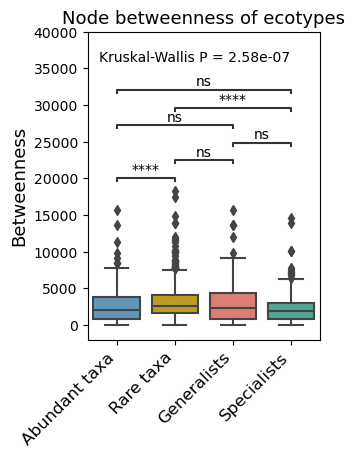

In [208]:
# Betweenness boxplot

ax = sns.boxplot(data=metrics_ecotype, x='Ecotype', y='betweenness', order=order, palette=group_colors)
annot = Annotator(ax, pairs, data=metrics_ecotype, x='Ecotype', y='betweenness', order=order)
annot.configure(test='Mann-Whitney', comparisons_correction="Benjamini-Hochberg", verbose=2)
annot.apply_test()
annot.annotate()
ax.set_xlabel('')
ax.set_ylabel('Betweenness', size=13)
ax.set_title('Node betweenness of ecotypes', size=13)

plt.text(0.05, 0.94, f'Kruskal-Wallis P = {kw_pval["betweenness"]:.2e}', fontsize=10, ha='left', va='top', transform=ax.transAxes)

plt.xticks(fontsize=12, rotation=45, ha='right')
plt.ylim(-2000, 40000)
plt.savefig('../output/network_betweenness_ecotypes.pdf', bbox_inches='tight', dpi=600)
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Abundant taxa vs. Rare taxa: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.585e-09 U_stat=6.427e+04
Rare taxa vs. Generalists: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.004e-01 U_stat=6.700e+04
Generalists vs. Specialists: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.649e-05 U_stat=1.560e+04
Abundant taxa vs. Generalists: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.158e-05 U_stat=1.157e+04
Rare taxa vs. Specialists: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.628e-07 U_stat=8.721e+04
Abundant taxa vs. Specialists: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.101e-01 U_stat=1.548e+04


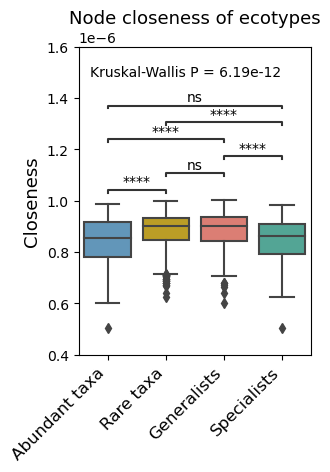

In [209]:
# Closeness boxplot

ax = sns.boxplot(data=metrics_ecotype, x='Ecotype', y='closeness', order=order, palette=group_colors)
annot = Annotator(ax, pairs, data=metrics_ecotype, x='Ecotype', y='closeness', order=order)
annot.configure(test='Mann-Whitney', comparisons_correction="Benjamini-Hochberg", verbose=2)
annot.apply_test()
annot.annotate()
ax.set_xlabel('')
ax.set_ylabel('Closeness', size=13)
ax.set_title('Node closeness of ecotypes', size=13)

plt.text(0.05, 0.94, f'Kruskal-Wallis P = {kw_pval["closeness"]:.2e}', fontsize=10, ha='left', va='top', transform=ax.transAxes)

plt.xticks(fontsize=12, rotation=45, ha='right')
plt.ylim(0.4e-6, 1.6e-6)
plt.savefig('../output/network_closeness_ecotypes.pdf', bbox_inches='tight', dpi=600)
plt.show()

# Network node metrics comparison for phyla

In [210]:
metrics_phyla = pd.merge(metrics_all, taxon[['Phylum']], left_index=True, right_index=True)

metrics_phyla_mean = metrics_phyla.groupby('Phylum').mean()

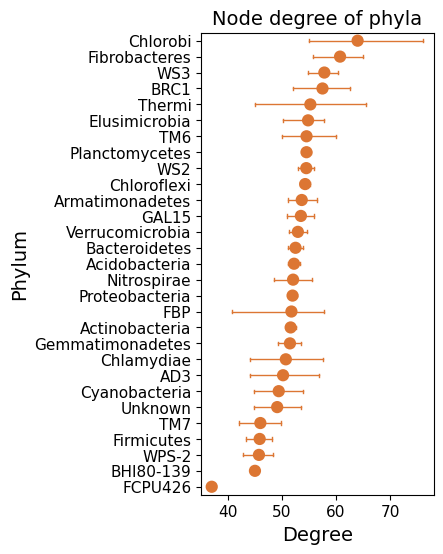

In [211]:
# Degree
order_degree = metrics_phyla_mean.sort_values(by='degree', ascending=False).index.to_list()

plt.rcParams["figure.figsize"] = (3, 6)

sns.pointplot(x='degree', y='Phylum', data=metrics_phyla, order=order_degree, join=False, capsize=0.2, errwidth=1, color='#DC7633')

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Phylum', size=14)
plt.xlabel('Degree', size=14)
plt.title('Node degree of phyla', size=14)
plt.savefig('../output/network_degree_phyla.pdf', bbox_inches='tight', dpi=600)
plt.show()

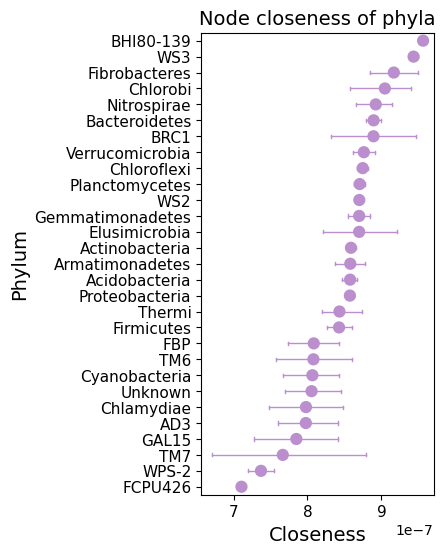

In [212]:
# Closeness
order_closeness = metrics_phyla_mean.sort_values(by='closeness', ascending=False).index.to_list()

plt.rcParams["figure.figsize"] = (3, 6)

sns.pointplot(x='closeness', y='Phylum', data=metrics_phyla, order=order_closeness, join=False, capsize=0.2, errwidth=1, color='#BB8FCE')

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Phylum', size=14)
plt.xlabel('Closeness', size=14)
plt.title('Node closeness of phyla', size=14)
plt.savefig('../output/network_closeness_phyla.pdf', bbox_inches='tight', dpi=600)
plt.show()

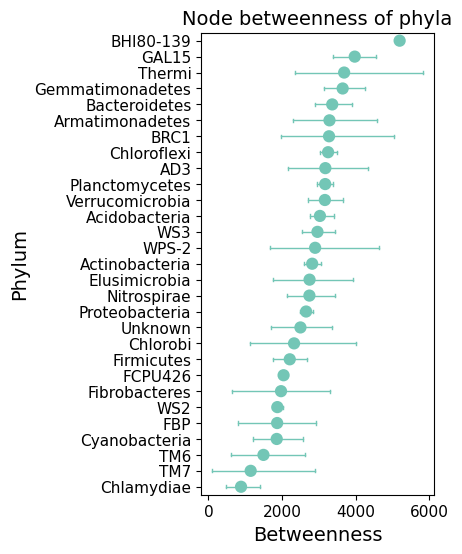

In [213]:
# Betweenness
order_betweenness = metrics_phyla_mean.sort_values(by='betweenness', ascending=False).index.to_list()

plt.rcParams["figure.figsize"] = (3, 6)

sns.pointplot(x='betweenness', y='Phylum', data=metrics_phyla, order=order_betweenness, join=False, capsize=0.2, errwidth=1, color='#73C6B6')

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Phylum', size=14)
plt.xlabel('Betweenness', size=14)
plt.title('Node betweenness of phyla', size=14)
plt.savefig('../output/network_betweenness_phyla.pdf', bbox_inches='tight', dpi=600)
plt.show()